In [43]:
import openmc
import os
import numpy as np
import neutronics_material_maker as nmm

# Define materials
# Tumor Material
tumor_material = openmc.Material(name='tumor')
tumor_material.add_nuclide('H1', 0.106)
tumor_material.add_nuclide('B10', 19.3e-4)
tumor_material.add_nuclide('B11', 85.3e-4)
tumor_material.add_nuclide('C12', 0.14)
tumor_material.add_nuclide('N14', 0.0184)
tumor_material.add_nuclide('O16', 0.726)
tumor_material.add_nuclide('Na22', 0.0014)
tumor_material.add_nuclide('P31', 0.0039)
tumor_material.add_element('Cl', 0.0014)
tumor_material.add_element('K', 0.0039)
tumor_material.set_density('g/cm3',1.0039)

# Regular Skin Material
skin_material = nmm.Material.from_library(name='Skin (ICRP)', material_id=1)
skin_material = skin_material.openmc_material


# Define materials collection and export to XML
my_materials = openmc.Materials([tumor_material, skin_material])
my_materials.export_to_xml()

# Set cross sections path
os.environ['OPENMC_CROSS_SECTIONS'] = "/Volumes/Untitled/cross_test/endfb-viii.0-hdf5/cross_sections.xml"

x_length_skin = 10
x_length_tumor = 10
y_length_skin = 0.4
y_length_tumor = 0.3
z_length_skin = 10
z_length_tumor = 10

# Create the rectangular box
skin_box = openmc.model.RectangularParallelepiped(-5,5,-0.4,0,-5,5)
tumor_box = openmc.model.RectangularParallelepiped(-5,5,-0.5,-0.4,-5,5)
currentx = 10
currenty = 0.4

sphere = openmc.Sphere(0,0,0,100, boundary_type='vacuum')
skin_box_cell = openmc.Cell(region=-skin_box, fill=skin_material)
tumor_box_cell = openmc.Cell(region=-tumor_box, fill=tumor_material)
sphere_cell = openmc.Cell(region=-sphere, fill=None)


# Define geometry
geometry = openmc.Geometry([skin_box_cell, tumor_box_cell, sphere_cell])
geometry.export_to_xml()

# Define source
point = openmc.stats.Point((0, 0, 0))

energy_distribution = openmc.stats.Discrete([500], [1])
source = openmc.Source(space=point, energy=energy_distribution)
source.angle = openmc.stats.Isotropic()

# Define settings
settings = openmc.Settings()
settings.batches = 2
settings.inactive = 0
settings.particles = 10000
settings.run_mode = 'fixed source'
settings.source = source
settings.export_to_xml()

# https://www.w3resource.com/numpy/array-creation/logspace.php
# neutrons from 10^-5 to 10^10 eV with 50 equally space bins
energy_bins = np.logspace(-5, 4, 50)

# Define filters
neutron_particle_filter = openmc.ParticleFilter(['neutron'])
skin_box_filter = openmc.CellFilter(skin_box_cell)
tumor_box_filter = openmc.CellFilter(tumor_box_cell)

# Define Dose Coefficients
energy_bins_n, dose_coeffs_n = openmc.data.dose_coefficients(particle="neutron", geometry="AP")
energy_function_filter_n = openmc.EnergyFunctionFilter(energy_bins_n, dose_coeffs_n)
energy_function_filter_n.interpolation = "cubic"  # cubic interpolation is recommended by ICRP

# Define tallies
# Calculate dose using dose coefficients
skin_flux = openmc.Tally(name="flux")
skin_flux.filters = [skin_box_filter, neutron_particle_filter]
skin_flux.scores=["flux"]

tumor_flux = openmc.Tally(name="flux")
tumor_flux.filters = [tumor_box_filter, neutron_particle_filter]
tumor_flux.scores=["flux"]


skin_na = openmc.Tally(name="skin_na")
skin_na.filters = [skin_box_filter, neutron_particle_filter, energy_function_filter_n, openmc.EnergyFilter(energy_bins)]
skin_na.scores = ["(n,a)"]

skin_ga = openmc.Tally(name="skin_ga")
skin_ga.filters = [skin_box_filter, neutron_particle_filter, energy_function_filter_n, openmc.EnergyFilter(energy_bins)]
skin_ga.scores = ["(n,gamma)"]

skin_np = openmc.Tally(name="skin_np")
skin_np.filters = [skin_box_filter, neutron_particle_filter, energy_function_filter_n, openmc.EnergyFilter(energy_bins)]
skin_np.scores = ["(n,p)"]

tumor_na = openmc.Tally(name="tumor_na")
tumor_na.filters = [tumor_box_filter, neutron_particle_filter, energy_function_filter_n, openmc.EnergyFilter(energy_bins)]
tumor_na.scores = ["(n,a)"]

tumor_ga = openmc.Tally(name="tumor_ga")
tumor_ga.filters = [tumor_box_filter, neutron_particle_filter, energy_function_filter_n, openmc.EnergyFilter(energy_bins)]
tumor_ga.scores = ["(n,gamma)"]

tumor_np = openmc.Tally(name="tumor_np")
tumor_np.filters = [tumor_box_filter, neutron_particle_filter, energy_function_filter_n, openmc.EnergyFilter(energy_bins)]
tumor_np.scores = ["(n,p)"]



my_tallies = openmc.Tallies([skin_flux, skin_na, skin_ga, skin_np, tumor_flux, tumor_na, tumor_ga, tumor_np])
settings.tallies = my_tallies

# Create the model and run simulation
model = openmc.model.Model(geometry, my_materials, settings, my_tallies)
openmc_exec = '/Users/arifv/opt/anaconda3/envs/new_env/bin/openmc'
!rm *.h5
model.run(openmc_exec=openmc_exec, output=False)


statepoint = openmc.StatePoint('statepoint.2.h5')

skin_flux = statepoint.tallies[skin_flux.id].mean
print("skin flux", skin_flux)
tumor_flux = statepoint.tallies[tumor_flux.id].mean
print("tumor flux", tumor_flux)

# Define RBE values for various interactions
tumor_doseDict = {1: {'name': 'tumor_na', 'conversion': 20,'RBE':3.8}, #n,a
            2: {'name': 'tumor_ga', 'conversion': 1, 'RBE':1},   #n,gamma
            3: {'name': 'tumor_np', 'conversion': 1, 'RBE': 3.2}    #n,p
           }

skin_doseDict = {1: {'name': 'skin_na', 'conversion': 20,'RBE':1.3}, #n,a
                2: {'name': 'skin_ga', 'conversion': 1, 'RBE':1},   #n,gamma
                3: {'name': 'skin_np', 'conversion': 1, 'RBE': 3.2}    #n,p
               }

D_TOT = 0
reg_D_TOT = 0
neutrons_per_second = 1e12 # Subject to change


tumor_na_results = statepoint.get_tally(name='tumor_na').mean.flatten()
tumor_ga_results = statepoint.get_tally(name='tumor_ga').mean.flatten()
tumor_np_results = statepoint.get_tally(name='tumor_np').mean.flatten()

skin_na_results = statepoint.get_tally(name='skin_na').mean.flatten()
skin_ga_results = statepoint.get_tally(name='skin_ga').mean.flatten()
skin_np_results = statepoint.get_tally(name='skin_np').mean.flatten()


tumor_dose = 0
skin_dose = 0

values = []

skin_volume_cm3 = x_length_skin * y_length_skin * z_length_skin
tumor_volume_cm3 = x_length_tumor * y_length_tumor * z_length_tumor

for i in range (1,4):
    for j, tally_result in enumerate(statepoint.get_tally(name=tumor_doseDict[i]['name']).mean.flatten()):
        tally_result = tally_result * tumor_flux.flatten() * neutrons_per_second
        tally_result = tally_result/tumor_volume_cm3
        tally_dose_pSv = tally_result * 60 * 60
        tally_dose_Sv = tally_dose_pSv * (1e-12)
        tally_dose_Gy = tally_dose_Sv/tumor_doseDict[i]['conversion']
        tumor_dose= tumor_dose + tally_dose_Gy * tumor_doseDict[i]['RBE']
    values.append(tumor_dose)
    print(i,"th",tumor_dose)
for i in range (1,4):
    for j, tally_result in enumerate(statepoint.get_tally(name=skin_doseDict[i]['name']).mean.flatten()):
        tally_result = tally_result * skin_flux.flatten() * neutrons_per_second
        tally_result = tally_result/skin_volume_cm3
        tally_dose_pSv = tally_result * 60 * 60
        tally_dose_Sv = tally_dose_pSv * (1e-12)
        tally_dose_Gy = tally_dose_Sv/skin_doseDict[i]['conversion']
        skin_dose= skin_dose + tally_dose_Gy * skin_doseDict[i]['RBE']
    values.append(skin_dose)
    print(i,"th",skin_dose)
print ("DTOT/hr:", tumor_dose)
print ("reg_DTOT/hr:", skin_dose)
print(values)

#currentVolume = str(10*currentx*currenty)
#with open('BNCTnumbers.txt', 'a') as f:
#    f.write('TUMOR (n,a) for width (x cm): '+ str(currentx)+ ' and depth (y cm): '+ str(currenty)+ ' is: '+ str(values[0])+ '. Volume is '+ currentVolume + " cm3 \n")
#    f.write('TUMOR (g,a) for width (x cm): '+str(currentx)+ ' and depth (y cm): '+ str(currenty)+ ' is: '+ str(values[1]-values[0])+ '. Volume is '+ currentVolume + " cm3 \n")
#    f.write('TUMOR (n,p) for width (x cm): '+ str(currentx)+ ' and depth (y cm): '+ str(currenty)+ ' is: '+ str(values[2]-values[1]-values[0])+ '. Volume is '+ currentVolume + " cm3 \n \n")

#    f.write('SKIN (n,a) for width (x cm): '+ str(currentx)+ ' and depth (y cm): '+ str(currenty)+ ' is: '+ str(values[3])+ '. Volume is '+ currentVolume + " cm3 \n")
#    f.write('SKIN (g,a) for width (x cm): '+ str(currentx)+ ' and depth (y cm): '+ str(currenty)+ ' is: '+ str(values[4]-values[3])+ '. Volume is '+ currentVolume+ " cm3 \n")
#    f.write('SKIN (n,p) for width (x cm): '+ str(currentx)+ ' and depth (y cm): '+ str(currenty)+ ' is: '+ str(values[5]-values[4]-values[3])+ '. Volume is '+ currentVolume + " cm3 \n \n \n")

/Users/arifv/opt/anaconda3/envs/new_env/lib/python3.8/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/Users/arifv/opt/anaconda3/envs/new_env/lib/python3.8/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=25.
  warn(msg, IDWarning)


skin flux [[[0.47681601]]]
tumor flux [[[0.06838569]]]
1 th [0.00290696]
2 th [0.00403307]
3 th [0.34988067]
1 th [1.59203577e-06]
2 th [0.03463167]
3 th [0.05425276]
DTOT/hr: [0.34988067]
reg_DTOT/hr: [0.05425276]
[array([0.00290696]), array([0.00403307]), array([0.34988067]), array([1.59203577e-06]), array([0.03463167]), array([0.05425276])]


In [48]:

tumor_depth_mm = [5,6,7,8] # distance from top of skin to bottom of tumor
tumor_depth_widths = [2,4,6,8,10] # x
tumor_depth_width_volumes = [] # in order, {5,2}, {5,4}, {5,6} etc
for i in range (0,len(tumor_depth_mm)):
    for j in range (0,len(tumor_depth_widths)):
        tumor_depth_width_volumes.append(tumor_depth_mm[i]*tumor_depth_widths[j]*10)


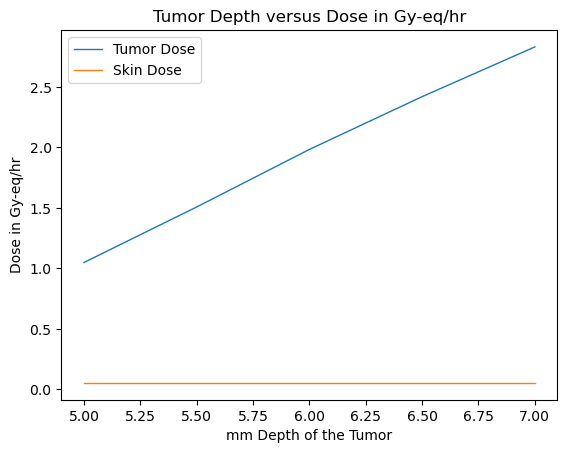

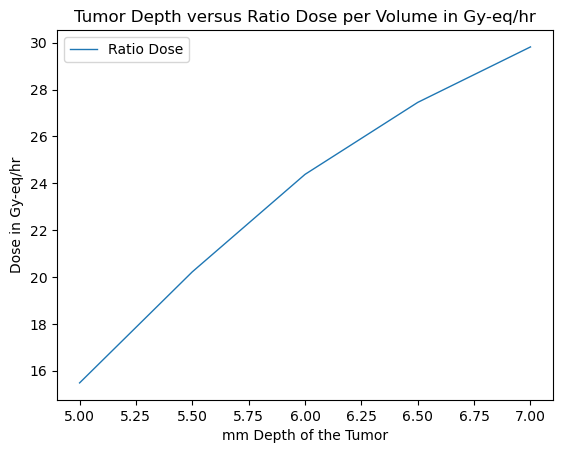

In [40]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
tumor_depth = [5, 5.5, 6, 6.5, 7] # in millimeters (mm) at constant 4 mm skin
tumor_dose = [1.04964202, 1.50832126, 1.98400353, 2.42023414, 2.83117693]
skin_dose = [0.05425276, 0.05425276, 0.05425276, 0.05425276, 0.05425276]

plt.figure()
plt.plot(tumor_depth, tumor_dose, linewidth=1, linestyle="-", label="Tumor Dose")
plt.plot(tumor_depth, skin_dose, linewidth=1, linestyle="-", label="Skin Dose")
plt.xlabel("mm Depth of the Tumor")
plt.ylabel("Dose in Gy-eq/hr")
plt.title('Tumor Depth versus Dose in Gy-eq/hr')
plt.legend()
plt.savefig('breslow_increase_slab.png')
plt.show()

skin_volume_cm3 = 10 * 10 * 0.4
tumor_volumes_cm3 = []
tumor_dose_cm3 = []
skin_dose_cm3 = []
ratio_dose = []
for i in range (0,len(tumor_dose)):
    tumor_volumes_cm3.append((tumor_depth[i]/10) * 10 * 10)
    tumor_dose_cm3.append(tumor_dose[i]/tumor_volumes_cm3[i])
    skin_dose_cm3.append(skin_dose[i]/skin_volume_cm3)
    ratio_dose.append(tumor_dose_cm3[i]/skin_dose_cm3[i])

plt.figure()
plt.plot(tumor_depth, ratio_dose, linewidth=1, linestyle="-", label="Ratio Dose")
plt.xlabel("mm Depth of the Tumor")
plt.ylabel("Dose in Gy-eq/hr")
plt.title('Tumor Depth versus Ratio Dose per Volume in Gy-eq/hr')
plt.legend()
#plt.savefig('ratio_dose_per_volume_slab.png')
plt.show()


In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np


tumor_na_results_converted = tumor_na_results * tumor_flux.flatten() * neutrons_per_second * 3600 * 3.8 * (1e-12)/(tumor_volume_cm3  * 20)
tumor_ga_results_converted = tumor_ga_results * tumor_flux.flatten() * neutrons_per_second * 3600 * 1.0 * (1e-12)/(tumor_volume_cm3)
tumor_np_results_converted = tumor_np_results * tumor_flux.flatten() * neutrons_per_second * 3600 * 3.2 * (1e-12)/(tumor_volume_cm3)

skin_na_results_converted = skin_na_results * skin_flux.flatten() * neutrons_per_second * 3600 * 1.3 * (1e-12)/(skin_volume_cm3  * 20)
skin_ga_results_converted = skin_ga_results * skin_flux.flatten() * neutrons_per_second * 3600 * 1.0 * (1e-12)/(skin_volume_cm3)
skin_np_results_converted = skin_np_results * skin_flux.flatten() * neutrons_per_second * 3600 * 3.2 * (1e-12)/(skin_volume_cm3)

energy_bins_cutoff = energy_bins[:49]

plt.figure()
plt.loglog(energy_bins_cutoff, tumor_na_results_converted, linewidth=1, linestyle="-", label="(n,a)")
plt.loglog(energy_bins_cutoff, tumor_ga_results_converted, linewidth=1, linestyle="-", label="(n,gamma)")
plt.loglog(energy_bins_cutoff, tumor_np_results_converted, linewidth=1, linestyle="-", label="(n,p)")
plt.xlabel("Incident Neutron Energy (eV)")
plt.ylabel("Dose per hour (Gy-eq/hr)")
plt.title('Incident Neutron Energy Versus Dose in the Tumor Region')
plt.legend()
plt.savefig('tumor_dose_all_01_slab.png')
plt.show()

plt.figure()
plt.loglog(energy_bins_cutoff, skin_na_results_converted, linewidth=1, linestyle="-", label="(n,a)")
plt.loglog(energy_bins_cutoff, skin_ga_results_converted, linewidth=1, linestyle="-", label="(n,gamma)")
plt.loglog(energy_bins_cutoff, skin_np_results_converted, linewidth=1, linestyle="-", label="(n,p)")
plt.xlabel("Incident Neutron Energy (eV)")
plt.ylabel("Dose per hour (Gy-eq/hr)")
plt.title('Incident Neutron Energy Versus Dose in the Healthy Region')
plt.legend()
plt.savefig('skin_dose_all_01_slab.png')
plt.show()


tumor_divided_skin_na = tumor_na_results_converted/skin_na_results_converted
tumor_divided_skin_ga = tumor_ga_results_converted/skin_ga_results_converted
tumor_divided_skin_np = tumor_np_results_converted/skin_np_results_converted

plt.figure()
plt.loglog(energy_bins_cutoff, tumor_divided_skin_na, linewidth=1, linestyle="-", label="(n,a)")
plt.loglog(energy_bins_cutoff, tumor_divided_skin_ga, linewidth=1, linestyle="-", label="(n,gamma)")
plt.loglog(energy_bins_cutoff, tumor_divided_skin_np, linewidth=1, linestyle="-", label="(n,p)")
plt.legend()
plt.xlabel("Incident Neutron Energy (eV)")
plt.ylabel("Dose per hour (Gy-eq/hr)")
plt.title("Incident Neutron Energy Versus Ratio of Dose in Tumor vs Healthy Region")
plt.savefig('dose_ratio_all_01_slab.png')
plt.legend()
plt.show()

NameError: name 'tumor_na_results' is not defined

In [27]:
import re

with open('BNCTnumbers.txt', 'r') as f:
    tumor_flag = False  # Flag to track tumor data
    with open('tumor_data.txt', 'w') as tumor_file, open('skin_data.txt', 'w') as skin_file:
        for line in f:
            match = re.match(r'.*\(x\s+cm\):\s+(\d+)\s+and\s+depth\s+\(y\s+cm\):\s+([\d.]+)\s+is:\s+\[([\d.e-]+)\].*', line)
            if match:
                x_value, y_value, z_value = match.groups()
                if "TUMOR" in line:
                    tumor_flag = True
                    tumor_file.write(f"({x_value}, {y_value}, {z_value})\n")
                elif "SKIN" in line:
                    tumor_flag = False
                    skin_file.write(f"({x_value}, {y_value}, {z_value})\n")


In [119]:
with open('BNCTnumbers.txt', 'r') as f:
    with open('cleanedData.txt', "w") as g:
        for line in f:
            s = line.split()
            for i,j in enumerate(s):
                if j == "cm):" and s[i-1] == "(x":
                    g.write("(" + str(s[i+1])+ ", ")
                elif j == "cm):":
                    g.write(str(s[i+1]) + ', ')
                if j == "is:":
                    newString = ""
                    for letter in s[i+1]:
                        if not letter == "[" and not letter == ']':
                            newString = newString + letter
                    g.write(newString+ ")" + "\n")


<_io.TextIOWrapper name='BNCTnumbers.txt' mode='r' encoding='UTF-8'>


x values: [2.0, 2.0, 2.0, 4.0, 4.0, 4.0, 6.0, 6.0, 6.0, 8.0, 8.0, 8.0, 10.0, 10.0, 10.0, 2.0, 2.0, 2.0, 4.0, 4.0, 4.0, 6.0, 6.0, 6.0, 8.0, 8.0, 8.0, 10.0, 10.0, 10.0, 2.0, 2.0, 2.0, 4.0, 4.0, 4.0, 6.0, 6.0, 6.0, 8.0, 8.0, 8.0, 10.0, 10.0, 10.0, 2.0, 2.0, 2.0, 4.0, 4.0, 4.0, 6.0, 6.0, 6.0, 8.0, 8.0, 8.0, 10.0, 10.0, 10.0]
y values: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2
 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4
 0.4 0.4 0.4 0.4 0.4 0.4]
z values: [1.59203577e-06 3.46300800e-02 1.96194900e-02 1.59203577e-06
 3.46300800e-02 1.96194900e-02 1.59203577e-06 3.46300800e-02
 1.96194900e-02 1.59203577e-06 3.46300800e-02 1.96194900e-02
 1.59203577e-06 3.46300800e-02 1.96194900e-02 1.59203577e-06
 3.46300800e-02 1.96194900e-02 1.59203577e-06 3.46300800e-02
 1.96194900e-02 1.59203577e-06 3.46300800e-02 1.96194900e-02
 1.59203577e-06 3.46300800e-02 1.96194900e-02 

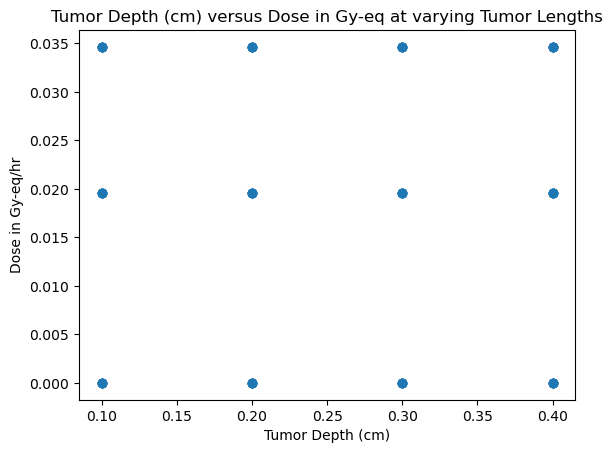

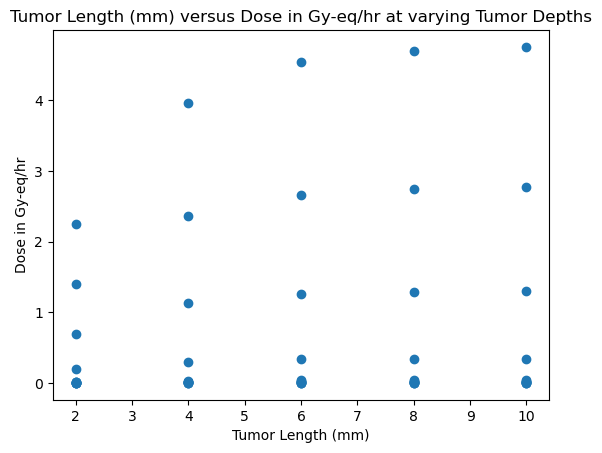

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

x_values_skin = []
y_values_skin = []
z_values_skin = []

x_values_tumor = []
y_values_tumor = []
z_values_tumor = []

# Read the data from the text file
with open("./skin_data.txt", "r") as file:
    for line in file:
        # Split each line into three values
        values = line.strip().split()
        if len(values) == 3:
            x_str, y_str, z_str = values
            x = float(x_str.strip('(),'))
            y = float(y_str.strip('(),'))
            z = float(z_str.strip('(),'))
            x_values_skin.append(x)
            y_values_skin.append(y)
            z_values_skin.append(z)

# Convert the lists to NumPy arrays
x_value_skin = np.array(x_values_skin)
y_values_skin = np.array(y_values_skin)
z_values_skin = np.array(z_values_skin)

print("x values:", x_values_skin)
print("y values:", y_values_skin)
print("z values:", z_values_skin)

# Read the data from the text file
with open("./tumor_data.txt", "r") as file:
    for line in file:
        # Split each line into three values
        values = line.strip().split()
        if len(values) == 3:
            x_str, y_str, z_str = values
            x = float(x_str.strip('(),'))
            y = float(y_str.strip('(),'))
            z = float(z_str.strip('(),'))
            x_values_tumor.append(x)
            y_values_tumor.append(y*10)
            z_values_tumor.append(z)

# Convert the lists to NumPy arrays
x_value_tumor = np.array(x_values_tumor)
y_values_tumor = np.array(y_values_tumor)
z_values_tumor = np.array(z_values_tumor)

print("x values:", x_values_tumor)
print("y values:", y_values_tumor)
print("z values:", z_values_tumor)

#fig = plt.figure(figsize=(12, 12))
#plt.title("Tumor Length (cm) versus Dose in Gy-eq at varying Tumor Depths")
#plt.xlabel("Tumor Length (cm)")
#plt.ylabel("Dose in Gy-eq/hr")
#ax = fig.add_subplot()
#ax.scatter(x_values, z_values)
#plt.show()


plt.figure()
plt.scatter(y_values_skin, z_values_skin)
plt.title("Tumor Depth (cm) versus Dose in Gy-eq at varying Tumor Lengths")
plt.xlabel("Tumor Depth (cm)")
plt.ylabel("Dose in Gy-eq/hr")
plt.show()

plt.figure()
plt.scatter(x_values_tumor, z_values_tumor)
plt.title("Tumor Length (mm) versus Dose in Gy-eq/hr at varying Tumor Depths")
plt.xlabel("Tumor Length (mm)")
plt.ylabel("Dose in Gy-eq/hr")
plt.savefig("tumor_length_vs_dose_slab.png")
plt.show()

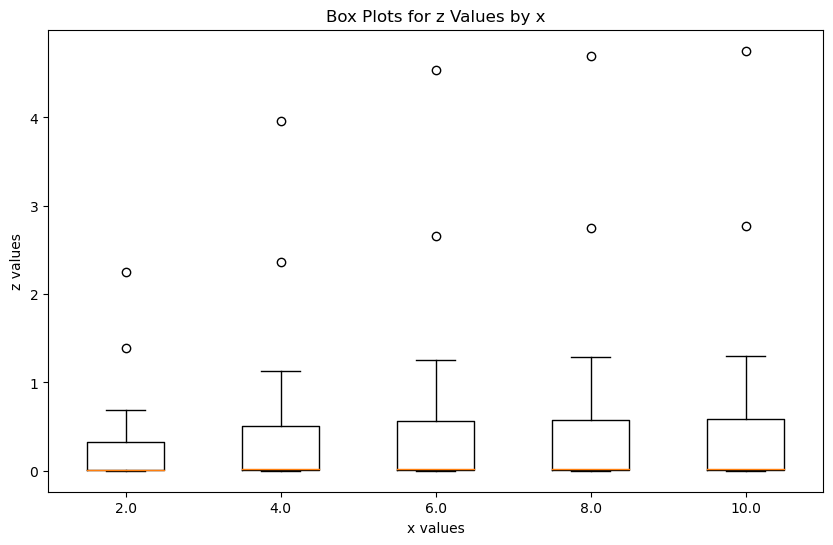

In [3]:
import numpy as np
import matplotlib.pyplot as plt
data = {}
for x, z in zip(x_values_tumor, z_values_tumor):
    if x not in data:
        data[x] = [z]
    else:
        data[x].append(z)

# Create a list of box plots for each x value
box_plots = [data[x] for x in sorted(data.keys())]

# Create the box plots
plt.figure(figsize=(10, 6))
plt.boxplot(box_plots, labels=sorted(data.keys()))
plt.title('Box Plots for z Values by x')
plt.xlabel('x values')
plt.ylabel('z values')
plt.show()